In [14]:
import mesa
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from ExtraChart import HistogramModule
import seaborn as sns
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import solara
from matplotlib.figure import Figure


In [12]:
def find_best_patch(model):
    agents = model.schedule.agents
    max_price = -float('inf')
    best_patch = None

    for agent in agents:
        if agent.price_at_mill > max_price:
            max_price = agent.price_at_mill
            best_patch = agent.pos

    return best_patch

def average_height(model):
    return np.mean([agent.height for agent in model.schedule.agents])

class PatchAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.sugar_content = random.uniform(0, 0.112)
        self.height = random.uniform(0, 2)
        self.price_at_mill = 0
        self.pos = None

    def step(self):
        if self.model.rain <= self.model.rain_probability:
            self.height += 0.00123 * 2
            self.sugar_content += 0.0000688 * 2
        else:
            self.height += 0.00123
            self.sugar_content += 0.0000688
            self.model.cashflow -= 0.3

        self.price_at_mill = self.calculate_price_at_mill()

        if (self.model.best_patch == self.pos and 
            self.height >= self.model.minimum_height_to_harvest and 
            self.model.current_harvesting_capacity > 0):
            self.being_harvested()
            self.model.current_harvesting_capacity -= 1

    def calculate_price_at_mill(self):
        if self.pos is None:
            raise ValueError("Agent position is not set.")
        x1, y1 = self.pos
        x2, y2 = 11, 0
        distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        price_at_mill = 14000 * (self.sugar_content * (1 - (distance * (0.6 / 16.9))))
        return round(price_at_mill, 2)

    def being_harvested(self):
        self.height = 0
        self.sugar_content = 0
        self.model.number_harvested += 1
        self.model.cashflow += self.price_at_mill
        self.model.cashflow -= 0.05

class FieldModel(Model):
    def __init__(self, width, height, minimum_height_to_harvest=2.4, harvesting_capacity_per_step=1, rain_probability=0.3):
        super().__init__()
        self.width = width
        self.height = height
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.rain = None
        self.best_patch = None
        self.harvesting_capacity_per_step = harvesting_capacity_per_step
        self.number_harvested = 0
        self.cashflow = 1000000
        self.minimum_height_to_harvest = minimum_height_to_harvest
        self.current_harvesting_capacity = self.harvesting_capacity_per_step
        self.rain_probability = rain_probability

        agent_id = 0
        for x in range(width):
            for y in range(height):
                if x == (width - 1) and y == 0:
                    continue
                
                a = PatchAgent(agent_id, self)
                self.schedule.add(a)
                self.grid.place_agent(a, (x, y))
                agent_id += 1

        self.datacollector = DataCollector(
            model_reporters={"Average Height": average_height, "Cashflow": "cashflow", "Number Harvested": "number_harvested"},
            agent_reporters={"Height": "height"}
        )

    def step(self):
        self.rain = random.uniform(0, 1)
        self.best_patch = find_best_patch(self)
        self.datacollector.collect(self)
        self.schedule.step()
        self.current_harvesting_capacity = self.harvesting_capacity_per_step

In [7]:
random.seed(100)

model = FieldModel(30, 30, minimum_height_to_harvest=2.4, harvesting_capacity_per_step=1, rain_probability = 0.3)
# model.step()
for i in range(3240):
    model.step()

### Code Optimization (Optional)

In [25]:
import cProfile
import pstats

In [15]:
def run_model():
    model = FieldModel(15, 15, minimum_height_to_harvest=2.4, harvesting_capacity_per_step=1, rain_probability = 0.3)
    for i in range(3240):
        model.step()

In [33]:
cProfile.run('run_model()', 'profile_stats')

In [34]:
with open('profile_report.txt', 'w') as f:
    p = pstats.Stats('profile_stats', stream=f)
    p.sort_stats('cumtime').print_stats(10)


## Result

<Axes: xlabel='Height', ylabel='Count'>

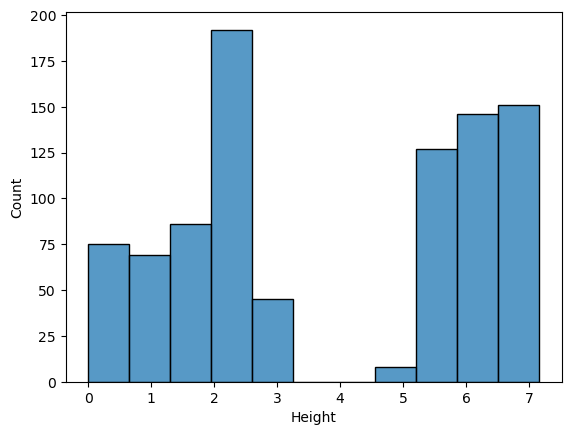

In [8]:
agent_height = model.datacollector.get_agent_vars_dataframe().reset_index()
agent_data = agent_height[agent_height['Step'] == 3239]

sns.histplot(data=agent_data, x='Height')


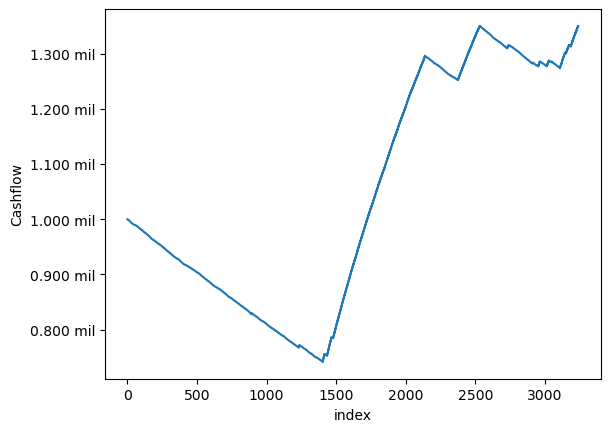

In [9]:
# Retrieve the model reporters' dataframe
model_df = model.datacollector.get_model_vars_dataframe().reset_index()


# Custom formatter function
def millions(x, pos):
    return '%1.3f mil' % (x * 1e-6)

# Plotting with Seaborn
sns.lineplot(data=model_df, y='Cashflow', x='index')

# Apply the custom formatter to the y-axis
formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()

<Axes: >

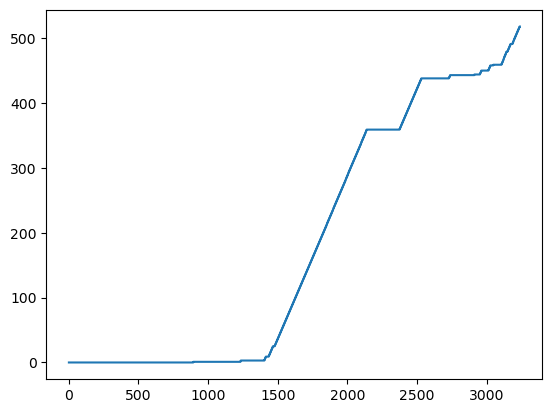

In [10]:
model_df['Number Harvested'].plot()

### Batch Run


In [11]:
params = {"width": 15, "height": 15, "minimum_height_to_harvest": [2.4, 4], "harvesting_capacity_per_step": [1, 4]}

results = mesa.batch_run(
    FieldModel,
    parameters=params,
    iterations=30,
    max_steps=3240,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/120 [00:00<?, ?it/s]

In [12]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height',
       'minimum_height_to_harvest', 'harvesting_capacity_per_step',
       'Average Height', 'Cashflow', 'Number Harvested'],
      dtype='object')


In [15]:
results_df.to_csv('results.csv', index=False)

In [2]:
results_df = pd.read_csv('results.csv')

In [3]:
results_df.head()

,RunId,iteration,Step,width,height,minimum_height_to_harvest,harvesting_capacity_per_step,Average Height,Cashflow,Number Harvested
0,0,0,0,15,15,2.4,1,0.959219,1000000.0,0
1,0,0,1,15,15,2.4,1,0.960449,999932.8,0
2,0,0,2,15,15,2.4,1,0.962909,999932.8,0
3,0,0,3,15,15,2.4,1,0.965369,999932.8,0
4,0,0,4,15,15,2.4,1,0.966599,999865.6,0


In [4]:
results_df.groupby(['minimum_height_to_harvest', 'harvesting_capacity_per_step'])['Cashflow'].mean().reset_index()

,minimum_height_to_harvest,harvesting_capacity_per_step,Cashflow
0,2.4,1,1.138541e+06
1,2.4,4,1.138927e+06
2,4.0,1,1.039733e+06
3,4.0,4,1.037958e+06


<Axes: xlabel='minimum_height_to_harvest', ylabel='Cashflow'>

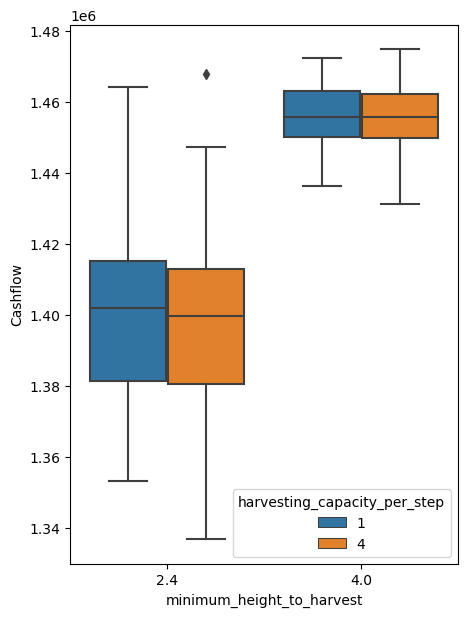

In [11]:
plt.figure(figsize=(5,7))
sns.boxplot(data=results_df[results_df['Step']==3240], x='minimum_height_to_harvest', y='Cashflow', hue='harvesting_capacity_per_step')

## Significance Test

In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming `results_df` is your DataFrame
anova_df = results_df[['minimum_height_to_harvest', 'harvesting_capacity_per_step', 'Cashflow']]

# Convert categorical variables to strings if they are not already
anova_df['minimum_height_to_harvest'] = anova_df['minimum_height_to_harvest'].astype(str)
anova_df['harvesting_capacity_per_step'] = anova_df['harvesting_capacity_per_step'].astype(str)

# Create the formula for ANOVA
formula = 'Cashflow ~ C(minimum_height_to_harvest) + C(harvesting_capacity_per_step) + C(minimum_height_to_harvest):C(harvesting_capacity_per_step)'

# Perform ANOVA
model = ols(formula, data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


C:\Users\Zak\AppData\Local\Temp\ipykernel_20212\4089155526.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_df['minimum_height_to_harvest'] = anova_df['minimum_height_to_harvest'].astype(str)
C:\Users\Zak\AppData\Local\Temp\ipykernel_20212\4089155526.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_df['harvesting_capacity_per_step'] = anova_df['harvesting_capacity_per_step'].astype(str)


,sum_sq,df,F,PR(>F)
C(minimum_height_to_harvest),9.701331e+14,1.0,31041.877373,0.000000
C(harvesting_capacity_per_step),4.691260e+10,1.0,1.501088,0.220505
C(minimum_height_to_harvest):C(harvesting_capacity_per_step),1.135549e+11,1.0,3.633479,0.056629
Residual,1.215456e+16,388916.0,NaN,NaN


In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=anova_df['Cashflow'], 
                          groups=anova_df['minimum_height_to_harvest'] + '-' + anova_df['harvesting_capacity_per_step'],
                          alpha=0.05)
print(tukey.summary())


       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
 2.4-1  2.4-4     386.0786 0.9632   -1673.7259   2445.8831  False
 2.4-1  4.0-1  -98807.8122    0.0 -100867.6167 -96748.0077   True
 2.4-1  4.0-4 -100583.1223    0.0 -102642.9268 -98523.3178   True
 2.4-4  4.0-1  -99193.8908    0.0 -101253.6953 -97134.0863   True
 2.4-4  4.0-4 -100969.2009    0.0 -103029.0054 -98909.3964   True
 4.0-1  4.0-4   -1775.3101 0.1193   -3835.1146    284.4944  False
-----------------------------------------------------------------


## Working on the rain probability

In [24]:
params = {"width": 15, "height": 15, "minimum_height_to_harvest": 4, "harvesting_capacity_per_step": 1, "rain_probability": [0.1, 0.3, 0.5]}

results = mesa.batch_run(
    FieldModel,
    parameters=params,
    iterations=30,
    max_steps=3240,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height',
       'minimum_height_to_harvest', 'harvesting_capacity_per_step',
       'rain_probability', 'Average Height', 'Cashflow', 'Number Harvested'],
      dtype='object')


Index(['RunId', 'iteration', 'Step', 'width', 'height',
       'minimum_height_to_harvest', 'harvesting_capacity_per_step',
       'rain_probability', 'Average Height', 'Cashflow', 'Number Harvested'],
      dtype='object')


In [30]:
results_df.to_csv('results_2.csv', index=False)

In [31]:
results_df.groupby(['rain_probability'])['Cashflow'].mean().reset_index()

,rain_probability,Cashflow
0,0.1,9.368264e+05
1,0.3,1.042539e+06
2,0.5,1.122378e+06


<Axes: xlabel='rain_probability', ylabel='Cashflow'>

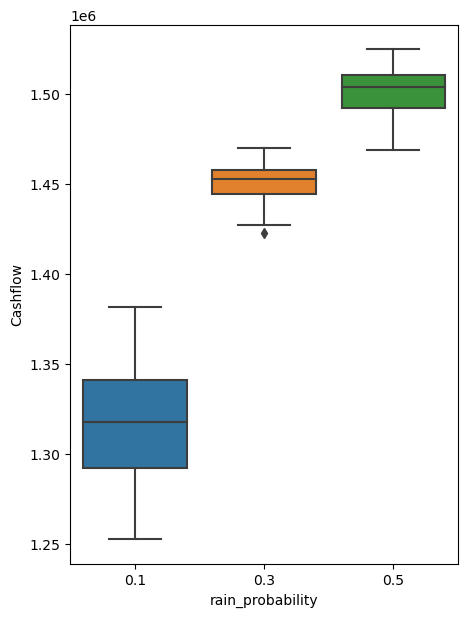

In [32]:
plt.figure(figsize=(5,7))
sns.boxplot(data=results_df[results_df['Step']==3240], x='rain_probability', y='Cashflow')

## Visualization

In [3]:
from mesa.experimental import JupyterViz

In [6]:
def agent_portrayal(agent):
    heights = [1, 2, 3, 4, 5]
    sizes = [5, 10, 20, 35, 50, 70]
    color = "tab:green"

    size = sizes[-1]  # Default to the largest size
    for i, height in enumerate(heights):
        if agent.height <= height:
            size = sizes[i]
            break

    return {"size": size, "color": color}

In [10]:
model_params = { 
    "width": 12,
    "height": 12, 
    "minimum_height_to_harvest": 2.4, 
    "harvesting_capacity_per_step": 1, 
    "rain_probability": 0.3
}

In [17]:
def make_histogram(model):
    # Note: you must initialize a figure using this method instead of
    # plt.figure(), for thread safety purpose
    fig = Figure()
    ax = fig.subplots()
    height_vals = [agent.height for agent in model.schedule.agents]
    # Convert wealth_vals to a numpy array for compatibility with seaborn
    height_vals = np.array(height_vals)
    # Note: you have to use Matplotlib's OOP API with seaborn
    sns.histplot(height_vals, bins=10, ax=ax, discrete=False)
    solara.FigureMatplotlib(fig)

In [18]:
page = JupyterViz(
    FieldModel,
    model_params,
    measures=["Average Height", make_histogram],
    name="Field Model",
    agent_portrayal=agent_portrayal,
)
# This is required to render the visualization in the Jupyter notebook
page

Cannot show ipywidgets in text

Socket opened!
{"type":"reset"}


In [4]:


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def agent_portrayal(agent):
    portrayal = {"Shape": "rect", "Filled": "true", "w": 0.5, "h": 0.5}

    heights = [1, 2, 3, 4, 5]
    sizes = [0.2, 0.4, 0.6, 0.8, 1, 1.2]
    colors = [
        rgb_to_hex((0, 0, 0)),        # black
        rgb_to_hex((0, 64, 0)),       # very dark green
        rgb_to_hex((0, 128, 0)),      # dark green
        rgb_to_hex((0, 192, 0)),      # medium green
        rgb_to_hex((0, 255, 0)),      # normal green
        rgb_to_hex((0, 255, 0))       # normal green for any height above 5
    ]

    for i, height in enumerate(heights):
        if agent.height <= height:
            portrayal["w"] = sizes[i]
            portrayal["h"] = sizes[i]
            portrayal["Color"] = colors[i]
            portrayal["Layer"] = 0
            break

    return portrayal

grid = mesa.visualization.CanvasGrid(agent_portrayal, 12, 12, 500, 500)

chart = mesa.visualization.ChartModule(
    [{"Label": "Cashflow", "Color": "Black"}], data_collector_name="datacollector"
)

histogram = HistogramModule(list(range(10)), 200, 500, attribute="height")

server = mesa.visualization.ModularServer(FieldModel,
                       [grid, 
                        # chart,
                        histogram
                        ],
                       "Field Model",
                       {"width":12, "height":12})
server.port = 8521 # The default
server.launch()


Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step